# A comparison of text representation methods

# Text representation: outline

- [String based](#string-based)
  - Character based
    - LCS distance
    - Edit distance
    - Jaro similarity
  - Phrase based
    - Dice
    - Jaccard 
- [Corpus based](#corpus-based)
  - Bag of word model
    - BOW
    - TF-IDF 
  - Shallow window based
    - Word2Vec
    - GloVe
    - BERT
- [Matrix factorization methods](#matrix-factorization)
  - LSA
  - LDA
- [Graph structure](#graph-based)
  - Knowledge graph
  - Graph neural network

In [19]:
import numpy as np
import pandas as pd

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from gensim.models import Word2Vec

import nltk
import jellyfish

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import fetch_20newsgroups

from transformers import BertTokenizer, BertModel
import torch

import spacy
import networkx as nx

plt.style.use("style.mplstyle")

colors = ["#003f5c", "#d45087", "#ffa600", "#665191", "#ff7c43", "#2f4b7c", "#f95d6a", "#a05195"]

cmap = ListedColormap(sns.color_palette(colors).as_hex())

## String Based

### Algorithms

In [20]:
def longest_common_substring(str1, str2):
    m = len(str1)
    n = len(str2)

    dp = [[0] * (n + 1) for _ in range(m + 1)]
    result = 0

    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                dp[i][j] = 0
            elif str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                result = max(result, dp[i][j])
            else:
                dp[i][j] = 0

    return result

def dice_coefficient(word1, word2):
    set1 = set(word1)
    set2 = set(word2)
    
    # Calculate intersection and union sizes
    intersection_size = len(set1.intersection(set2))
    union_size = len(set1) + len(set2)
    
    # Avoid division by zero
    if union_size == 0:
        return 0.0
    
    # Calculate Dice coefficient
    dice_coeff = (2.0 * intersection_size) / union_size
    
    return dice_coeff

def jaccard_similarity(word1, word2):
    set1 = set(word1)
    set2 = set(word2)
    
    # Calculate intersection and union sizes
    intersection_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))
    
    # Avoid division by zero
    if union_size == 0:
        return 0.0
    
    # Calculate Jaccard similarity coefficient
    jaccard_coeff = float(intersection_size) / union_size
    
    return jaccard_coeff

def levenshtein_matrix(s1, s2):
    m, n = len(s1), len(s2)
    d = np.zeros((m+1, n+1))
    for i in range(m+1):
        d[i, 0] = i
    for j in range(n+1):
        d[0, j] = j
    for j in range(1, n+1):
        for i in range(1, m+1):
            if s1[i-1] == s2[j-1]:
                substitution_cost = 0
            else:
                substitution_cost = 1
            d[i, j] = min(d[i-1, j] + 1,                   # deletion
                          d[i, j-1] + 1,                   # insertion
                          d[i-1, j-1] + substitution_cost) # substitution
    return d

In [21]:
document1 = "The sky is blue"
document2 = "The sun is bright"

levenshtein_dist = nltk.edit_distance(document1, document2)
lcs_dist = longest_common_substring(document1, document2)   
jaro_sim = jellyfish.jaro_similarity(document1, document2)

print(f"Levenshtein distance between {document1} and {document2}: {levenshtein_dist:.2f}")
print(f"Longest common substring distance between {document1} and {document2}: {lcs_dist:.2f}")
print(f"Jaro similarity between {document1} and {document2}: {jaro_sim:.2f}")

Levenshtein distance between The sky is blue and The sun is bright: 7.00
Longest common substring distance between The sky is blue and The sun is bright: 5.00
Jaro similarity between The sky is blue and The sun is bright: 0.75


In [22]:
document1 = "The sky is blue"
document2 = "The sky is blue"

levenshtein_dist = nltk.edit_distance(document1, document2)
lcs_dist = longest_common_substring(document1, document2)   
jaro_sim = jellyfish.jaro_similarity(document1, document2)

print(f"Levenshtein distance between {document1} and {document2}: {levenshtein_dist:.2f}")
print(f"Longest common substring distance between {document1} and {document2}: {lcs_dist:.2f}")
print(f"Jaro similarity between {document1} and {document2}: {jaro_sim:.2f}")

Levenshtein distance between The sky is blue and The sky is blue: 0.00
Longest common substring distance between The sky is blue and The sky is blue: 15.00
Jaro similarity between The sky is blue and The sky is blue: 1.00


In [23]:
# Example of entity identification
da = pd.DataFrame({"customer_id": [109238, 1132125, 159483, 198828], 
                   "birth": ["07-12-87", "23-08-89", "28-11-90", "22-12-92"], 
                   "city": ["Rome", "London", "Paris", "Bristol"]})

da.head()

,customer_id,birth,city
0,109238,07-12-87,Rome
1,1132125,23-08-89,London
2,159483,28-11-90,Paris
3,198828,22-12-92,Bristol


In [24]:
db = pd.DataFrame({"order_numb": [121212, 151892, 312526, 418825], 
                  "cust_numb": [109238, 1132125, 159483, 19882],
                  "cost": [100, 200, 300, 400],
                  "city": ["Rome", "London", "Paris", "Bristol"]})

db.head()

,order_numb,cust_numb,cost,city
0,121212,109238,100,Rome
1,151892,1132125,200,London
2,312526,159483,300,Paris
3,418825,19882,400,Bristol


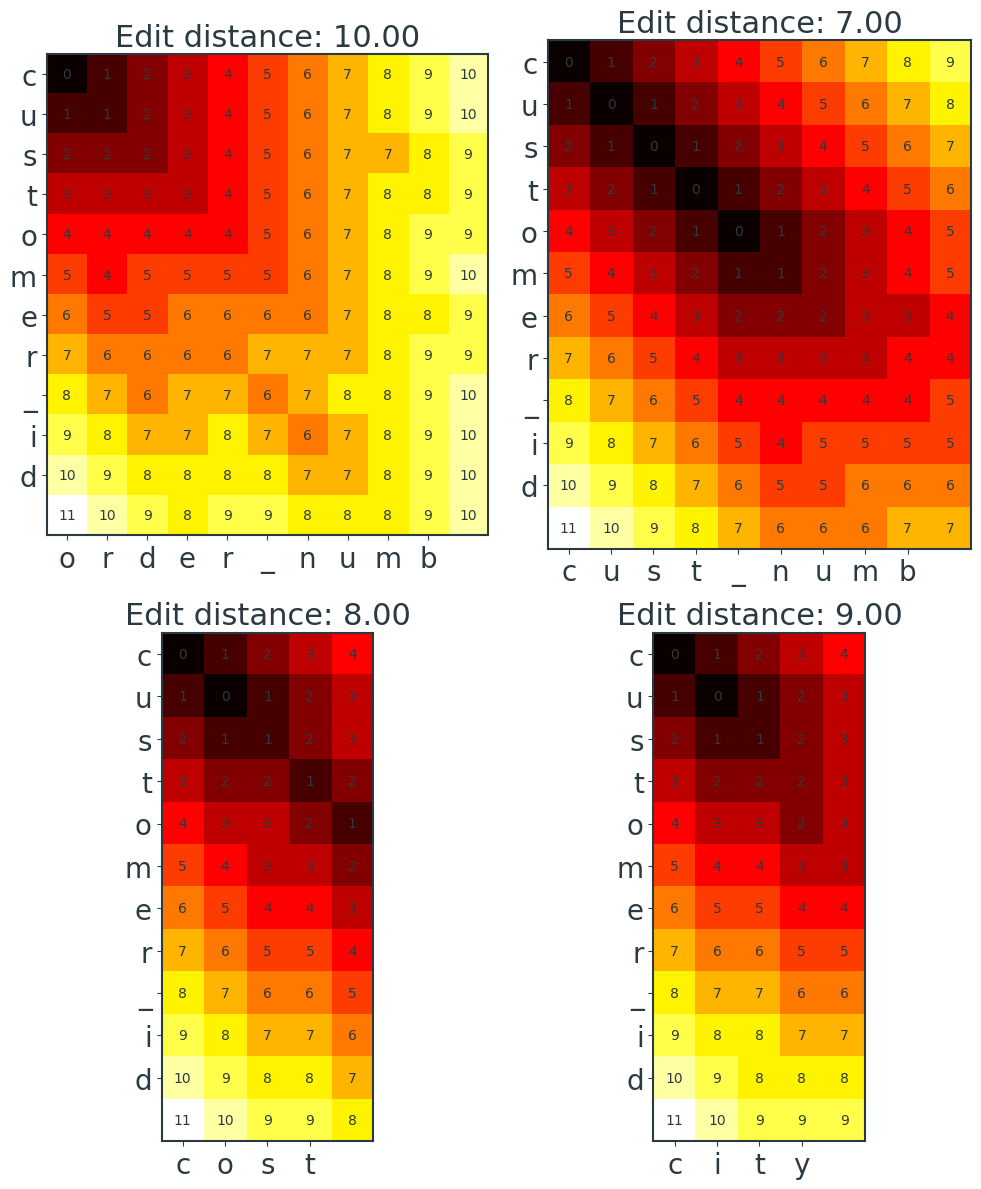

In [25]:
target_col = da.columns[0]

fig, ax = plt.subplots(2, 2, figsize=(10, 12))

# Calculate edit distance between target column and each column in the target dataframe
images = []
for idx, column in enumerate(db.columns):
    if idx >= 4:  # We only have 4 subplots
        break
    distance = nltk.edit_distance(target_col, column)
    d = levenshtein_matrix(target_col, column)
    i, j = divmod(idx, 2)  # Convert flat index to 2D index
    im = ax[i, j].imshow(d, cmap="hot", interpolation="nearest")
    images.append(im)
    ax[i, j].set_xticks(np.arange(len(column)))
    ax[i, j].set_yticks(np.arange(len(target_col)))
    ax[i, j].set_xticklabels(list(column), fontsize=20)
    ax[i, j].set_yticklabels(list(target_col), fontsize=20)
    ax[i, j].set_title(f"Edit distance: {distance:.2f}")
    for x in range(d.shape[0]):
        for y in range(d.shape[1]):
            ax[i, j].text(y, x, int(d[x, y]), ha='center', va='center')

plt.tight_layout()
plt.show()

In [26]:
document1 = "The sky is blue"
document2 = "The sun is bright"

print(f"Dice coefficient between {document1} and {document2}: {dice_coefficient(document1, document2):.2f}")
print(f"Jaccard similarity between {document1} and {document2}: {jaccard_similarity(document1, document2):.2f}")

Dice coefficient between The sky is blue and The sun is bright: 0.70
Jaccard similarity between The sky is blue and The sun is bright: 0.53


## Corpus Based

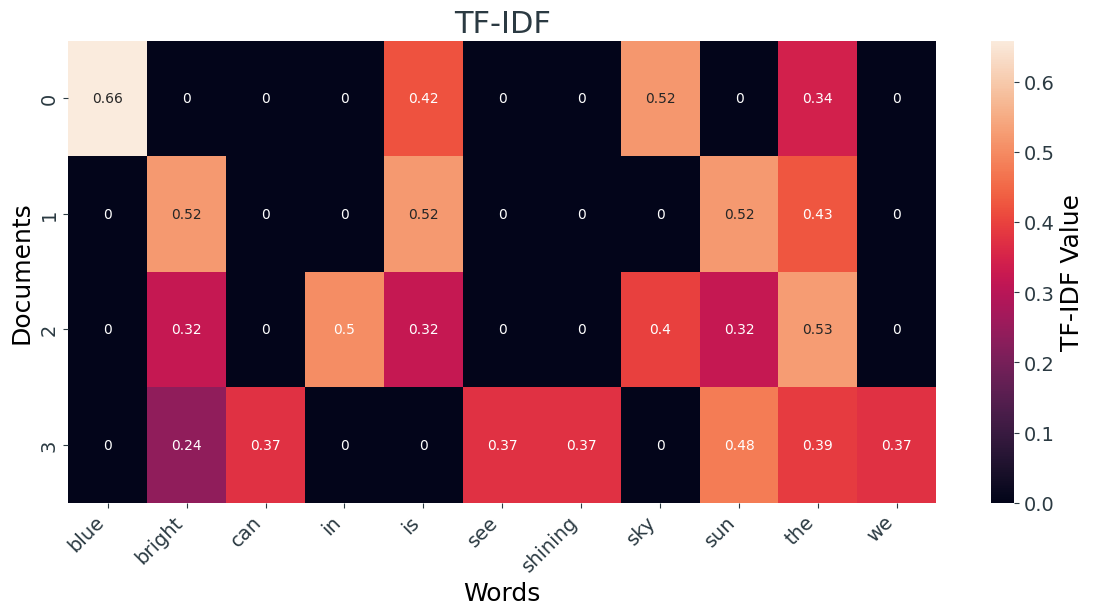

In [27]:
# Define a corpus of text
corpus = [
    'The sky is blue',
    'The sun is bright',
    'The sun in the sky is bright',
    'We can see the shining sun, the bright sun'
]

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(corpus)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a dense matrix for easier inspection
dense_matrix = tfidf_matrix.todense()

# Create a DataFrame for better visualization
df = pd.DataFrame(dense_matrix, columns=feature_names)

# Plot the heatmap
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(df, cmap='rocket', annot=True, cbar_kws={'label': 'TF-IDF Value'})

# Set x-axis labels as legends
heatmap.set_xticklabels(feature_names, rotation=45, ha='right')

plt.title('TF-IDF')
plt.xlabel('Words')
plt.ylabel('Documents')
plt.show()

## Shallow Window based

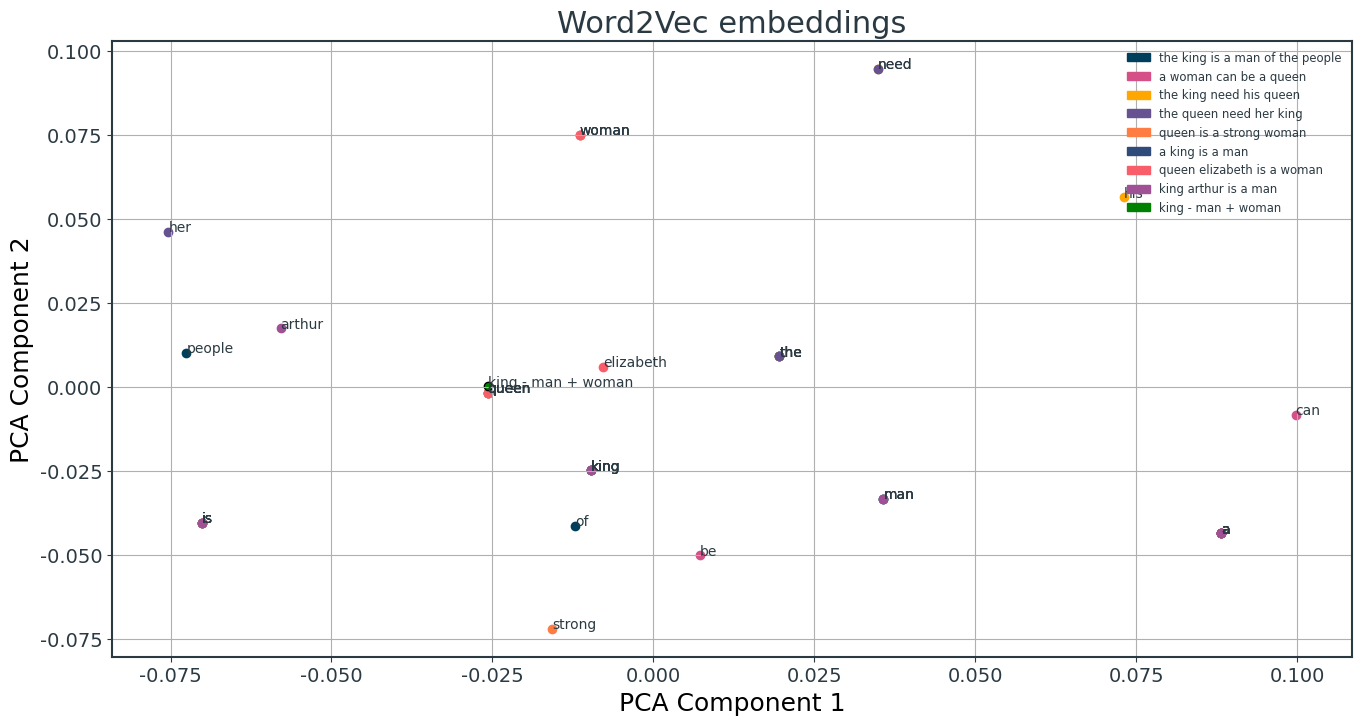

In [28]:
import matplotlib.patches as mpatches

# Tokenize sentences
og_sentences = [
    "the king is a man of the people",
    "a woman can be a queen",
    "the king need his queen",
    "the queen need her king",
    "queen is a strong woman",
    "a king is a man",
    "queen elizabeth is a woman",
    "king arthur is a man"
]

sentences = [nltk.word_tokenize(sentence) for sentence in og_sentences]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=20, window=5, min_count=1, workers=4)

# Get all word vectors
word_vectors = model.wv.vectors

# Fit a PCA model to the word vectors
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Create a scatter plot of the word vectors
plt.figure(figsize=(16, 8))

# Add labels to the points
for i, sentence in enumerate(sentences):
    for word in sentence:
        if word in model.wv:
            word_vector_2d = pca.transform(model.wv[word].reshape(1, -1))
            plt.scatter(word_vector_2d[:, 0], word_vector_2d[:, 1], color=colors[i % len(colors)])
            plt.annotate(word, xy=(word_vector_2d[0, 0], word_vector_2d[0, 1]))


# Create a list of patches for the legend
legend_patches = [Patch(color=colors[i % len(colors)], label=sentence) for i, sentence in enumerate(og_sentences)]

# Perform vector operation "king - man + woman"
result = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
word_vector_2d = pca.transform(model.wv[result[0][0]].reshape(1, -1))
plt.scatter(word_vector_2d[:, 0], word_vector_2d[:, 1] + 0.002, color='green', ec='black')
plt.annotate("king - man + woman", xy=(word_vector_2d[0, 0], word_vector_2d[0, 1] + 0.002))

# Create a list of patches for the legend
legend_patches = [mpatches.Patch(color=colors[i % len(colors)], label=sentence) for i, sentence in enumerate(og_sentences)]
legend_patches.append(mpatches.Patch(color='green', label='king - man + woman'))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.title('Word2Vec embeddings')
plt.legend(handles=legend_patches, loc='upper right', fontsize='small')
plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


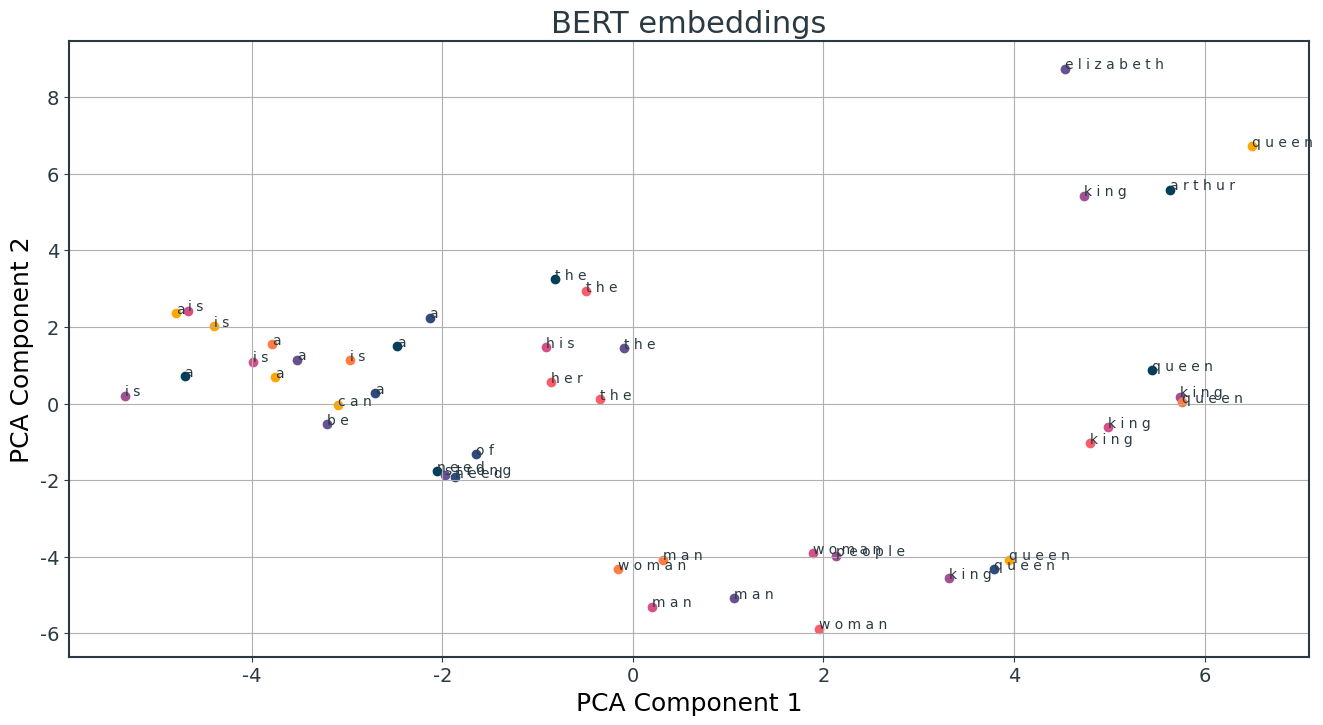

In [33]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Set the model in evaluation mode to deactivate the DropOut modules
model.eval()

# Tokenize sentences and get BERT embeddings
word_embeddings = []
words = []
for sentence in og_sentences:
    # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True)])  
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples
    # get the embedding of each word
    for i in range(1, len(input_ids[0]) - 1):  # Skip the first and last token ([CLS] and [SEP])
        word_embeddings.append(last_hidden_states[0,i,:].numpy())
        words.append(tokenizer.decode(input_ids[0][i]))

# Fit a PCA model to the embeddings
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_embeddings)

# Create a scatter plot of the embeddings
plt.figure(figsize=(16, 8))

# Add labels to the points
for i, (word_embedding_2d, word) in enumerate(zip(word_embeddings_2d, words)):
    plt.scatter(word_embedding_2d[0], word_embedding_2d[1])
    plt.annotate(word, xy=(word_embedding_2d[0], word_embedding_2d[1]))

legend_patches = [mpatches.Patch(color=colors[i % len(colors)], label=sentence) for i, sentence in enumerate(og_sentences)]
plt.legend(handles=legend_patches, loc='upper right', fontsize='small')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend()
plt.title('BERT embeddings')
plt.show()

## Matrix factorization

In [30]:
# Load example data
categories = ['sci.space', 'rec.sport.baseball', 'comp.graphics']
data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data.data)

# Apply Latent Semantic Analysis using TruncatedSVD
num_topics = 5
lsa = TruncatedSVD(n_components=num_topics)
lsa_result = lsa.fit_transform(X)

# Display the top words for each topic
terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lsa.components_):
    top_words_indices = topic.argsort()[-5:][::-1]
    top_words = [terms[idx] for idx in top_words_indices]
    print(f"Topic {i + 1}: {', '.join(top_words)}")

Topic 1: space, like, don, know, year
Topic 2: thanks, graphics, files, image, space
Topic 3: space, nasa, launch, shuttle, orbit
Topic 4: graphics, just, don, think, aspects
Topic 5: thanks, mail, list, advance, space


## Semantic text matching

## Graph based

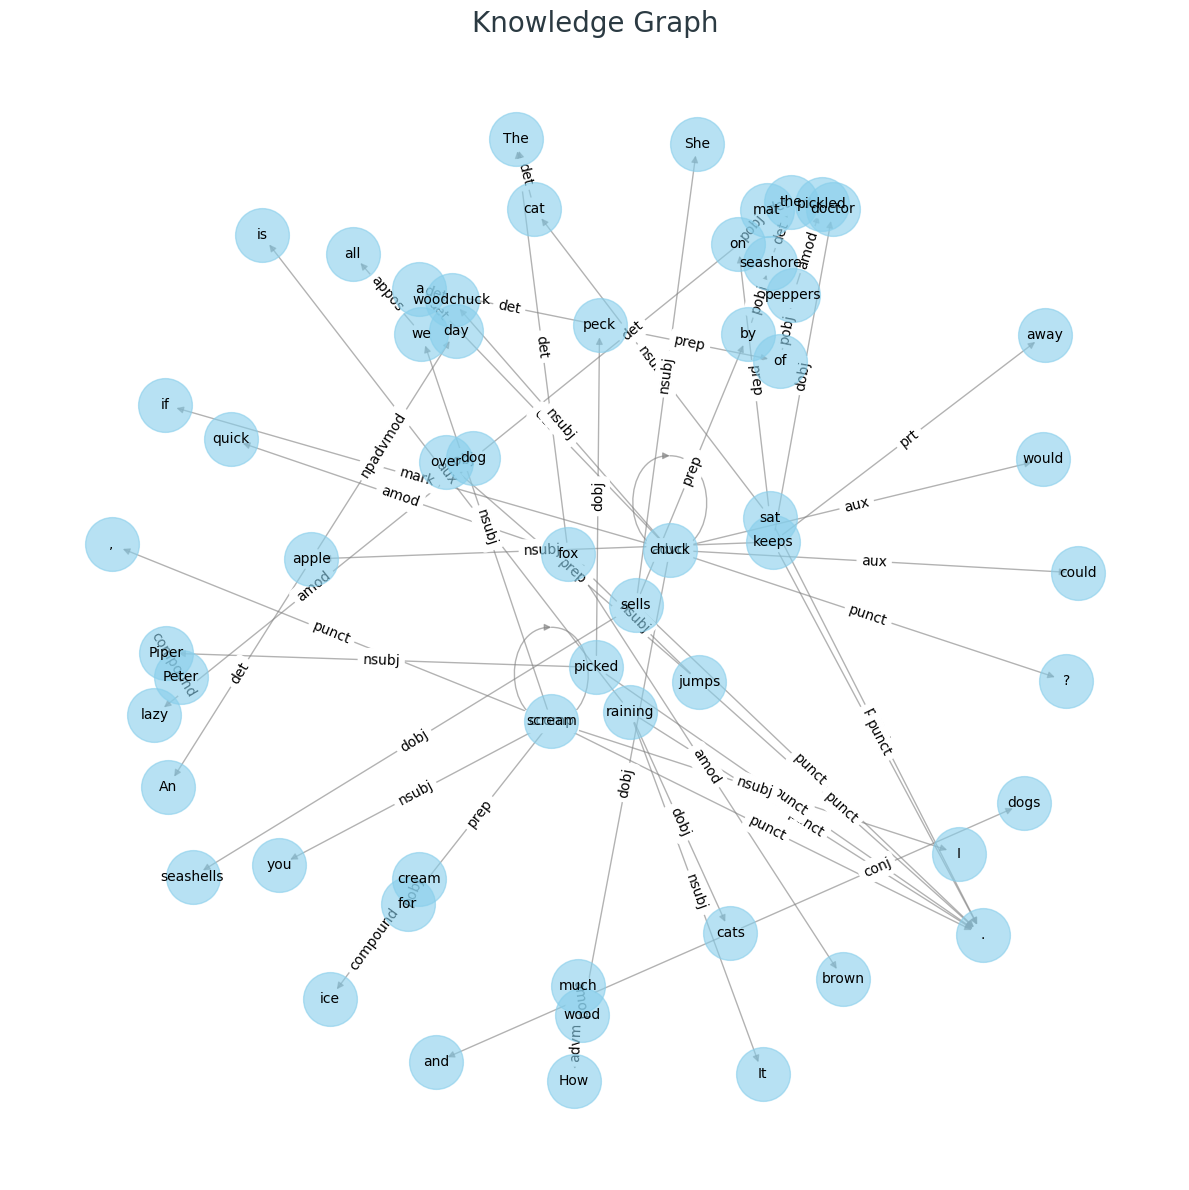

In [31]:
sentences = [
    "The cat sat on the mat.",
    "The quick brown fox jumps over the lazy dog.",
    "It is raining cats and dogs.",
    "An apple a day keeps the doctor away.",
    "She sells seashells by the seashore.",
    "Peter Piper picked a peck of pickled peppers.",
    "How much wood would a woodchuck chuck if a woodchuck could chuck wood?",
    "I scream, you scream, we all scream for ice cream.",
]

# Load the spacy model
nlp = spacy.load('en_core_web_md')

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges for each sentence
for sentence in sentences:
    doc = nlp(sentence)
    for token in doc:
        # Add nodes
        G.add_node(token.text)
        # Add edges
        if token.dep_ != 'ROOT':
            G.add_edge(token.head.text, token.text, label=token.dep_)

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Set a seed for reproducible layout
plt.figure(figsize=(12, 12))  # Increase figure size

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1500, alpha=0.6)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Knowledge Graph', size=20)
plt.axis('off')  # Turn off the axis
plt.tight_layout()  # Improve appearance